In [8]:
from calendar_ipynb.google_oauth import verify_credentials
from calendar_ipynb.events import fetch_events, filter_out_future_events, sort_events, handle_overlapping_event_durations, insert_untracked_times
from calendar_ipynb.ipywidgets.calendar_selection import (
    select_calendars,
    get_selected_calendars,
)
from calendar_ipynb.ipywidgets.date_range_selection import get_selected_date_range
from calendar_ipynb.meta import classify_events

%matplotlib widget
%load_ext autoreload
# Automatically reload all modules
%autoreload 2

EMAIL_IDS = ["fahimalizain@gmail.com", "fahim.zain@kwalee.com"]

for email in EMAIL_IDS:
    verify_credentials(email)

INFO:calendar_ipynb.google_oauth:✅ Credentials found for fahimalizain@gmail.com
INFO:calendar_ipynb.google_oauth:✅ Credentials found for fahim.zain@kwalee.com


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
select_calendars(EMAIL_IDS)
selected_calendars = get_selected_calendars()
if not selected_calendars:
    raise ValueError("No calendars selected")

INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0


In [10]:
from_date, to_date = get_selected_date_range()
if not from_date or not to_date:
    raise ValueError("Please provide from_date and to_date")

print("Date Range:", from_date, " TO ", to_date)

Date Range: 2025-02-09 00:00:00  TO  2025-02-23 23:59:59


In [11]:
events = []
for email, calendars in get_selected_calendars().items():
    for calendar in calendars:
        events.extend(
            fetch_events(
                email=email,
                calendar_id=calendar,
                from_datetime=from_date,
                to_datetime=to_date,
            )
        )
events = filter_out_future_events(events)
events = sort_events(events)
events = handle_overlapping_event_durations(events)
events = insert_untracked_times(events)
events = classify_events(events)

INFO:calendar_ipynb.events:Fetching events from 2025-02-09 00:00:00 to 2025-02-23 23:59:59 for fahimalizain@gmail.com
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:calendar_ipynb.events:Fetching events from 2025-02-09 00:00:00 to 2025-02-23 23:59:59 for fahimalizain@gmail.com
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:calendar_ipynb.events:Fetching events from 2025-02-09 00:00:00 to 2025-02-23 23:59:59 for fahimalizain@gmail.com
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:calendar_ipynb.events:Fetching events from 2025-02-09 00:00:00 to 2025-02-23 23:59:59 for fahimalizain@gmail.com
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:calendar_ipynb.events:Fetching events from 2025-02-09 00:00:00 to 2025-02-23 23:59:59 for fahim.zain@kwalee.com
INFO:googleapiclient.discovery_cache:file_cache is 

In [12]:
[x for x in events if x["start"]["dateTime"].startswith("2025-02-22")]

[{'summary': '105.0 min | Untracked',
  'start': {'dateTime': '2025-02-22T00:00:00+00:00', 'timeZone': 'UTC'},
  'end': {'dateTime': '2025-02-22T01:45:00+00:00', 'timeZone': 'UTC'},
  'visibility': 'default',
  'status': 'confirmed',
  'duration_min': 105.0,
  'categories': [('untracked', 'Untracked')]},
 {'kind': 'calendar#event',
  'etag': '"3480384479263230"',
  'id': '9819b4d070724f83a085633cc4c496aa',
  'status': 'confirmed',
  'htmlLink': 'https://www.google.com/calendar/event?eid=OTgxOWI0ZDA3MDcyNGY4M2EwODU2MzNjYzRjNDk2YWEgZXN2YWc0ZmJiOHExOTJxM2tzaXBxaDVkMmdAZw',
  'created': '2025-02-22T02:43:41.000Z',
  'updated': '2025-02-22T02:43:59.631Z',
  'summary': 'Woke Up (4 / 27)',
  'description': '<ul><li>Wake up on Alarm before Sunrise</li></ul>',
  'colorId': '6',
  'creator': {'email': 'fahimalizain@gmail.com'},
  'organizer': {'email': 'esvag4fbb8q192q3ksipqh5d2g@group.calendar.google.com',
   'displayName': 'Personal Goals',
   'self': True},
  'start': {'dateTime': '2025-02-22

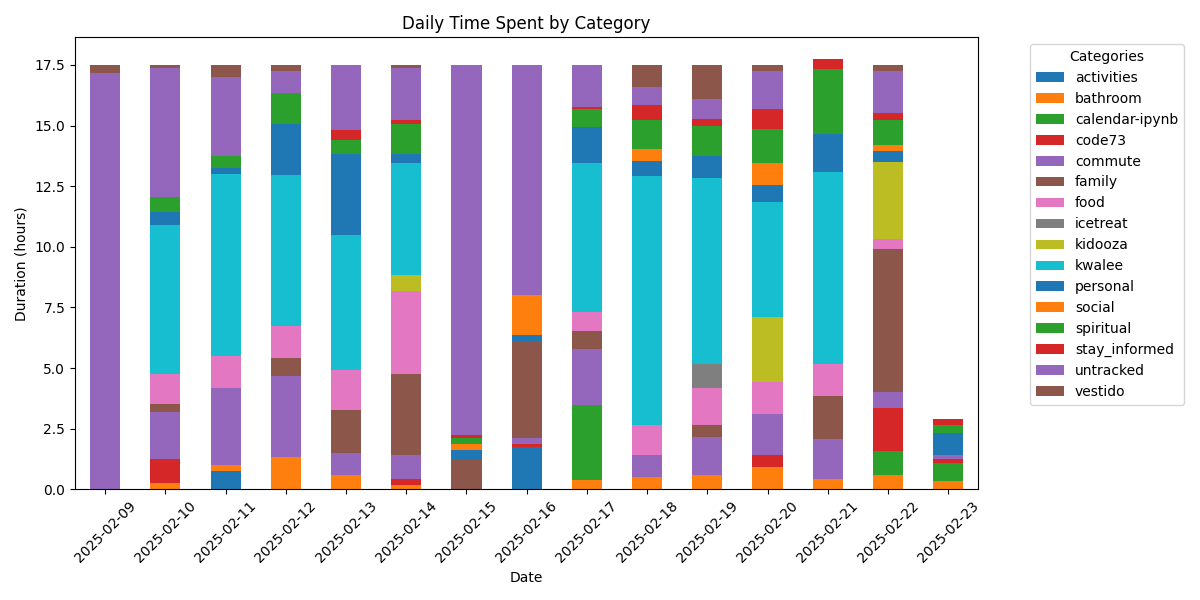

In [13]:
from calendar_ipynb.ipywidgets.bargraph_grouped_by_day import show_bargraph

show_bargraph(events)

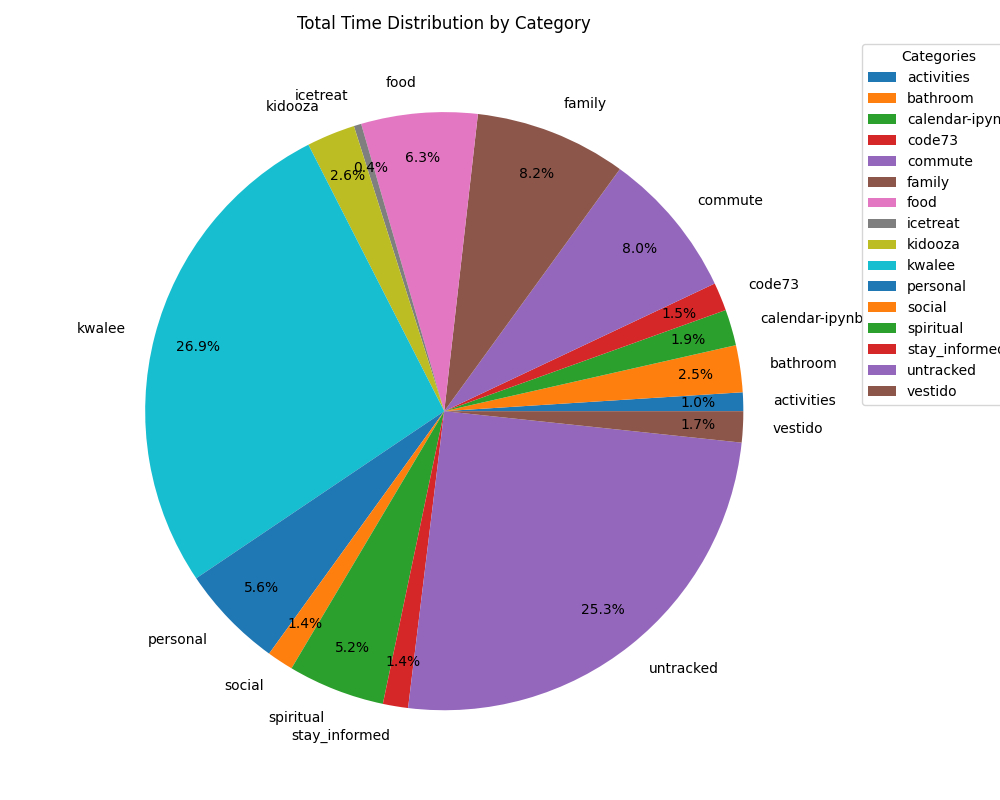

In [14]:
from calendar_ipynb.ipywidgets.piechart import show_piechart

show_piechart(events)